In [0]:
## use of external code

# this link helped us understand how to implement WGAN with gradient penalty, and after that DCGAN was easier to implement:
# https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
# this link gave us an implementation of minibatch discrimination
# https://github.com/sanghviyashiitb/GANS-VanillaAndMinibatchDiscrimination/blob/master/minibatch_discrimination.py

## mount google drive

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## import libraries and data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import random
from glob import glob

## settings

saveNetworks = False
torch.manual_seed(6)
trainSetSize = 500
numOfLabels = 10

## hyper parameters

numOfDistributionsVec = [30, 10, 50]
batchSize = 50  # number of data points in each batch
numOfEpochs = 1000  # times to run the model on complete data
latentDimVec = [30, 50, 10]  # latent vector dimension
generatorLearningRateVec = [0.0002, 0.0005, 0.001]  # learning rate
discriminatorLearningRateVec = [0.0002, 0.0005, 0.001]  # learning rate
numOfChannels = 1
b1 = 0.5
b2 = 0.999

miniBatchDiscriminationB = 5
miniBatchDiscriminationC = 100
clipValueVec = [5, 0.3, 0.1] #[5, 3, 2, 1, 0.5, 0.2, 10, 20]


##
## calculate inception  score
def calculateModifiedInceptionScore(preds):
    splits=10 			# the number of splits to average the score over
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    #print(preds)		# Predicted labels using the output of the transfer learnt architecture
    scores = []
    # Calculating the inception score
    for i in range(splits):
        part = preds[np.argmax(preds,axis=1)==i]
        logp= np.log(part)
        self = np.sum(part*logp,axis=1)
        cross = np.mean(np.dot(part,np.transpose(logp)),axis=1)
        diff = self - cross
        kl = np.mean(self - cross)
        kl1 = []
        for j in range(splits):
            diffj = diff[(j * diff.shape[0] // splits):((j+ 1) * diff.shape[0] //splits)]
            kl1.append(np.exp(diffj.mean()))
        print("category: %s scores_mean = %.2f, scores_std = %.2f" % (classes[i], np.mean(kl1),np.std(kl1)))
        scores.append(np.exp(kl))
    print("scores_mean = %.2f, scores_std = %.2f" % (np.mean(scores),
                                                    np.std(scores)))
    return scores

## load MNSIT classifier

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

MNISTclassifier = Net().to(device)
classifierPath = F"/content/gdrive/My Drive/project_321089724_302363965/MNIST Inception Score/mnist_cnn.pt"
filename = glob(classifierPath)[0]
MNISTclassifier.load_state_dict(torch.load(filename))


for latentDim in latentDimVec:
  for numOfDistributions in numOfDistributionsVec:
    for clipValue in clipValueVec:
      for generatorLearningRate in generatorLearningRateVec:
        for discriminatorLearningRate in discriminatorLearningRateVec:
        

          ## load data
          trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ]))

          device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
          print(device)

          ## create a subset of labeled data (do this for each option of "numOfLabeledSamplesVector", usually: [3000,1000,600,100])

          samplesPerLabel = int(trainSetSize / numOfLabels)
          chosenIndices = list()
          for i in range(numOfLabels):
              chosenIndices += random.choices(np.where(trainset.targets == i)[0], k=samplesPerLabel)
          sampler = torch.utils.data.SubsetRandomSampler(chosenIndices)
          trainLoader = torch.utils.data.DataLoader(
              trainset, batch_size=batchSize, shuffle=False,
              sampler=SubsetRandomSampler(chosenIndices))


          class MiniBatchDiscrimination(nn.Module):
              def __init__(self, A, B, C, batch_size):
                  super(MiniBatchDiscrimination, self).__init__()
                  self.feat_num = A
                  self.out_size = B
                  self.row_size = C
                  self.N = batch_size
                  self.T = Parameter(torch.Tensor(A, B, C).to(device))
                  self.reset_parameters()

              def forward(self, x):
                  # Output matrices after matrix multiplication
                  M = x.mm(self.T.view(self.feat_num, self.out_size * self.row_size)).view(-1, self.out_size, self.row_size)
                  out = Variable(torch.zeros(self.N, self.out_size).to(device))
                  for k in range(self.N):
                      c = torch.exp(-torch.sum(torch.abs(M[k, :] - M), 2))  # exp(-L1 Norm of Rows difference)
                      if k != 0 and k != self.N - 1:
                          out[k, :] = torch.sum(c[0:k, :], 0) + torch.sum(c[k:-1, :], 0)
                      else:
                          if k == 0:
                              out[k, :] = torch.sum(c[1:, :], 0)
                          else:
                              out[k, :] = torch.sum(c[0:self.N - 1], 0)
                  return out

              def reset_parameters(self):
                  stddev = 1 / self.feat_num
                  self.T.data.uniform_(stddev)


          ## define the net classes
          class Generator(torch.nn.Module):
              def __init__(self, latentDim, numOfDistributions):
                  super().__init__()

                  mu = 2 * torch.rand(numOfDistributions, latentDim) - 1
                  mu.requires_grad = True
                  self.mu = Parameter(mu)

                  sigma = 0.2 * torch.ones(numOfDistributions, latentDim)
                  sigma.requires_grad = True
                  self.sigma = Parameter(sigma)

                  self.fc1 = nn.Linear(latentDim, 1024, bias=True)
                  self.fc1BatchNorm1d = nn.BatchNorm1d(num_features=1024)

                  self.deConv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
                  self.deConv1BatchNorm2d = nn.BatchNorm2d(num_features=32)

                  self.deConv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1)
                  self.deConv2BatchNorm2d = nn.BatchNorm2d(num_features=16)

                  self.deConv3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=2)

              def forward(self, x):

                  chosenGaussian = random.randint(0,numOfDistributions-1)
                  x = x * self.sigma[chosenGaussian, :].expand(x.shape) + self.mu[chosenGaussian, :].expand(x.shape)

                  x = self.fc1(x)
                  x = self.fc1BatchNorm1d(x)
                  x = torch.relu(x)

                  x = x.view(-1, 16*4, 4, 4)
                  x = self.deConv1(x)
                  x = self.deConv1BatchNorm2d(x)
                  x = torch.relu(x)

                  x = self.deConv2(x)
                  x = self.deConv2BatchNorm2d(x)
                  x = torch.relu(x)

                  x = self.deConv3(x)
                  x = torch.tanh(x)

                  return x


          class Discriminator(torch.nn.Module):
              def __init__(self, miniBatchDiscriminationB, miniBatchDiscriminationC):
                  super().__init__()

                  self.out_feat_num = 32

                  self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=2)
                  self.leakyRelu = nn.LeakyReLU(0.9, inplace=True)

                  self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=2)
                  self.conv2BatchNorm2d = nn.BatchNorm2d(16)

                  self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
                  self.conv3BatchNorm2d = nn.BatchNorm2d(self.out_feat_num)

                  self.maxPool = nn.MaxPool2d(4, stride=1)

                  #self.miniBatchDiscrimination = MiniBatchDiscrimination(A=self.out_feat_num, B=miniBatchDiscriminationB,
                  #                                                      C=miniBatchDiscriminationC, batch_size=batchSize)

                  #self.fc = nn.Linear(self.out_feat_num + miniBatchDiscriminationB, 1, bias=True)
                  self.fc = nn.Linear(self.out_feat_num, 1, bias=True)

              def forward(self, x):
                  x = self.conv1(x)
                  x = self.leakyRelu(x)

                  x = self.conv2(x)
                  x = self.conv2BatchNorm2d(x)
                  x = self.leakyRelu(x)

                  x = self.conv3(x)
                  x = self.conv3BatchNorm2d(x)
                  x = self.leakyRelu(x)

                  x = self.maxPool(x)

                  x = x.view(-1, self.out_feat_num)
                  #x = torch.cat((x,self.miniBatchDiscrimination(x)), 1)

                  x = self.fc(x)

                  return x


          generator = Generator(latentDim, numOfDistributions)  # create a generative net
          discriminator = Discriminator(miniBatchDiscriminationB, miniBatchDiscriminationC)  # create a discriminative net

          generator.to(device)
          discriminator.to(device)
          print(generator)
          print(discriminator)

          ## optimizers and loss function
          generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=generatorLearningRate, betas=(b1, b2))
          discriminatorOptimizer = torch.optim.AdamW(discriminator.parameters(), lr=discriminatorLearningRate, betas=(b1, b2))
          lossFunction = nn.BCEWithLogitsLoss()

          ## some initializations
          realLabels = torch.ones(batchSize).to(device)
          fakeLabels = torch.zeros(batchSize).to(device)
          generatorLossVector = list()
          discriminatorLossVector = list()
          cnt = 0

          ## main loop!
          while cnt < numOfEpochs:
              for i, data in enumerate(trainLoader, 0):
                  inputs = data[0].to(device) * 2 - 1
                  if len(inputs) < batchSize:
                      continue

                  for p in discriminator.parameters():
                      p.requires_grad = True
                  for p in discriminator.parameters():
                      p.data.clamp_(-clipValue, clipValue)  # GRADIENT CLIP

                  # some initializations
                  discriminatorLossReal = 0
                  discriminatorLossFake = 0

                  # Train discriminator on real images
                  discriminatorResultOnReal = discriminator(inputs).view(batchSize)
                  discriminatorLossReal = lossFunction(discriminatorResultOnReal, realLabels)

                  # Train with fake images
                  z = torch.randn(batchSize, latentDim).to(device)
                  fakeInput = generator(z)
                  discriminatorResultOnFake = discriminator(fakeInput).view(batchSize)
                  discriminatorLossFake = lossFunction(discriminatorResultOnFake, fakeLabels)

                  # discriminator loss + step
                  discriminatorLoss = discriminatorLossReal + discriminatorLossFake
                  discriminator.zero_grad()
                  discriminatorLoss.backward()
                  discriminatorOptimizer.step()

                  # Generator update
                  for p in discriminator.parameters():
                      p.requires_grad = False  # to avoid computation

                  generator.zero_grad()

                  # compute loss with fake images
                  z = torch.randn(batchSize, latentDim).to(device)
                  fakeInput = generator(z)
                  discriminatorResultOnFake = discriminator(fakeInput).view(batchSize)
                  sigmaRegulizer = 0.01 * torch.mean(torch.pow(1-generator.sigma, 2))
                  generatorLoss = lossFunction(discriminatorResultOnFake, realLabels) + sigmaRegulizer
                  generatorLoss.backward()
                  generatorOptimizer.step()

              cnt = cnt + 1
              discriminatorLossVector.append(discriminatorLoss)
              generatorLossVector.append(generatorLoss)
              # if (cnt == numOfEpochs-1):
              #   if generatorLossVector[-1] < min(generatorLossVector[-50:-1]):
              #     print('good enough: ' + str(generatorLossVector[-1]))
              #     break
              #   else:
              #     cnt = cnt - 1
              #     print('not good enough: ' + str(generatorLossVector[-1]))
                
                
              ## plot losses, print logs and show some images every once in a while
              #if (cnt >= 2000) and (cnt % 1000 == 0):
              # learningRateMultiplicationFactor = ((numOfEpochs/1000) - cnt/1000) / ((numOfEpochs/1000)-1)
              # generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=learningRate * learningRateMultiplicationFactor, betas=betas)
              # discriminatorOptimizer = torch.optim.AdamW(discriminator.parameters(), lr=learningRate * learningRateMultiplicationFactor, betas=betas)

              if cnt % 500 == 499:

                print("finished ", cnt + 1, " epochs")
                print("discriminator loss: ", discriminatorLoss.item())
                print("generator loss: ", generatorLoss.item())
                print("real image:")
                y=(inputs[4][0]*0.5+0.5).cpu().detach().numpy()
                plt.figure()
                plt.imshow(y, cm.gray, vmin=0, vmax=1)
                plt.show()
                print("fake image:")
                y=(fakeInput[4][0]*0.5+0.5).cpu().detach().numpy()
                plt.figure()
                plt.imshow(y, cm.gray, vmin=0, vmax=1)
                plt.show()

                plt.figure()
                plt.plot(range(len(generatorLossVector)),generatorLossVector,range(len(discriminatorLossVector)),discriminatorLossVector)
                plt.xlabel('epoch number')
                plt.ylabel('loss function')
                plt.legend(('generator', 'discriminator'), loc='upper right')
                plt.title('epochs vs loss function DELIGAN')
                plt.grid(True)
                plt.show()
                

          if saveNetworks == True:
              generator_save_name = 'generator with clip ' + str(clipValue) +'  epoch '+ str(cnt) +'generatorLoss: '+ str(round(1000*generatorLoss.item())/1000) +'.pt'
              modelPath = F"/content/gdrive/My Drive/project_321089724_302363965/trained_models/trained_DELIGAN/{generator_save_name}"
              torch.save(generator.state_dict(), modelPath)

          numberOfImagesToBeDisplayed = 16
          with torch.no_grad():   
            z = torch.randn(numberOfImagesToBeDisplayed, latentDim).to(device)  
            fakeInput = generator(z)
            plt.figure()
            y=(fakeInput[:,0,:,:]*0.5+0.5).cpu().detach().numpy()
            for i in range(numberOfImagesToBeDisplayed):
              plt.subplot(numberOfImagesToBeDisplayed**0.5,numberOfImagesToBeDisplayed**0.5,i+1)
              plt.imshow(y[i], cm.gray, vmin=0, vmax=1)
          plt.show()
          print("latentDim: ", latentDim, " numOfDistributions: ", numOfDistributions, " clip: ", clipValue, " gen lr: ", generatorLearningRate, " disc lr: ", discriminatorLearningRate)
          with torch.no_grad():
            z = torch.randn(10000, latentDim).to(device)
            fakeInput = generator(z)
            preds = torch.exp(MNISTclassifier(fakeInput)).detach().cpu().numpy()
            scores = calculateModifiedInceptionScore(preds)




Output hidden; open in https://colab.research.google.com to view.

In [4]:
import torch
torch.rand((2,3,4)).shape

torch.Size([2, 3, 4])

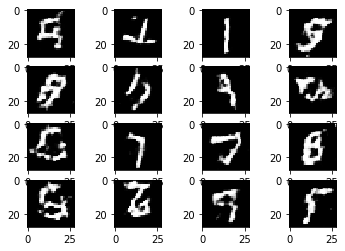

In [0]:
numberOfImagesToBeDisplayed = 16
with torch.no_grad():   
  z = torch.randn(numberOfImagesToBeDisplayed, latentDim).to(device)  
  fakeInput = generator(z)
  plt.figure()
  y=(fakeInput[:,0,:,:]*0.5+0.5).cpu().detach().numpy()
  for i in range(numberOfImagesToBeDisplayed):
    plt.subplot(numberOfImagesToBeDisplayed**0.5,numberOfImagesToBeDisplayed**0.5,i+1)
    plt.imshow(y[i], cm.gray, vmin=0, vmax=1)
plt.show()